In [1]:
#verifying gpu
import torch
torch.cuda.is_available()

True

In [2]:
#installing required libraries
!pip install -q transformers datasets accelerate bitsandbytes peft sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 12.1 MB/s eta 0:00:00


In [3]:
#loading the dataset
from datasets import load_dataset

dataset = load_dataset("go_emotions")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [4]:
#coverting 27 emotions to 5
label_names = dataset["train"].features["labels"].feature.names
print(label_names)

emotion_groups = {
    "anger": ["anger", "annoyance", "disapproval"],
    "sadness": ["sadness", "disappointment", "grief", "remorse", "embarrassment"],
    "anxiety": ["fear", "nervousness", "confusion"],
    "positive": ["joy", "love", "gratitude", "admiration", "approval", "excitement", "optimism", "relief", "pride", "caring", "desire"],
    "neutral": ["neutral"]
}

label_to_group = {}

for idx, name in enumerate(label_names):
    for group, emotions in emotion_groups.items():
        if name in emotions:
            label_to_group[idx] = group

def convert_labels(example):
    if len(example["labels"]) > 0:
        original_label = example["labels"][0]
        example["label_text"] = label_to_group.get(original_label, "neutral")
    else:
        example["label_text"] = "neutral"
    return example

dataset = dataset.map(convert_labels)

final_labels = ["anger", "sadness", "anxiety", "positive", "neutral"]

label_encoding = {label: i for i, label in enumerate(final_labels)}
print(label_encoding)

def encode_labels(example):
    example["labels"] = label_encoding[example["label_text"]]
    return example

dataset = dataset.map(encode_labels)

dataset = dataset.remove_columns(["label_text"])
dataset["train"][0]

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

{'anger': 0, 'sadness': 1, 'anxiety': 2, 'positive': 3, 'neutral': 4}


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

{'text': "My favourite food is anything I didn't have to cook myself.",
 'labels': 4,
 'id': 'eebbqej'}

In [5]:
#text preprocessing
import re

#cleaning text
def clean_text(example):
    text = example["text"]

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+", "", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    example["text"] = text
    return example

dataset = dataset.map(clean_text)

#removing very short samples
def remove_short(example):
    return len(example["text"].split()) > 2

dataset = dataset.filter(remove_short)

from collections import Counter

train_labels = dataset["train"]["labels"]
Counter(train_labels)

#tokenization
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        max_length=128
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset = tokenized_dataset.remove_columns(
    ["text"]
)

tokenized_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

tokenized_dataset["train"][0]

from datasets import DatasetDict

train_test = tokenized_dataset["train"].train_test_split(test_size=0.1)

dataset = DatasetDict({
    "train": train_test["train"],
    "validation": train_test["test"],
    "test": tokenized_dataset["test"]
})

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/42362 [00:00<?, ? examples/s]

Map:   0%|          | 0/5296 [00:00<?, ? examples/s]

Map:   0%|          | 0/5308 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.out_proj.bias        | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.762076,0.762012,0.707340,0.700577,0.699623,0.707340
2,0.646095,0.773916,0.699080,0.697853,0.697313,0.699080


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye


Test Results:
{'eval_loss': 0.7173370718955994, 'eval_accuracy': 0.725320271288621, 'eval_f1': 0.7184318702036708, 'eval_precision': 0.7197826459681408, 'eval_recall': 0.725320271288621, 'eval_runtime': 11.1602, 'eval_samples_per_second': 475.618, 'eval_steps_per_second': 29.749, 'epoch': 2.0}


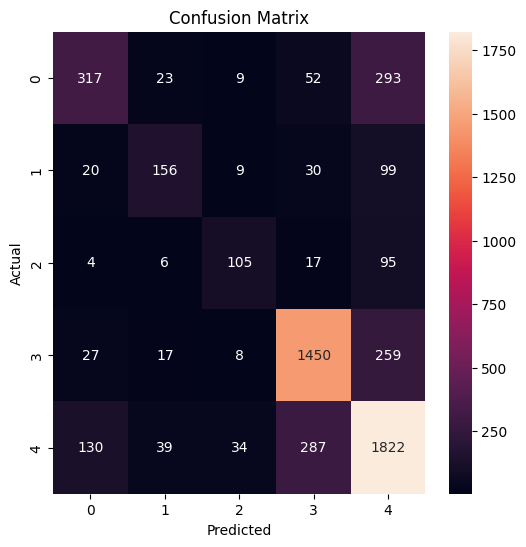

In [6]:
#RoBERTa classification model
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

#Load Model
num_labels = 5

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=num_labels
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#Define Evaluation Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted"
    )
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

#Training Configuration
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none"
)
#Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

#Train
trainer.train()

#Evaluate on Test Set
results = trainer.evaluate(dataset["test"])
print("\nTest Results:")
print(results)

#Confusion Matrix
predictions = trainer.predict(dataset["test"])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

Baseline Model Results:
Accuracy: 0.6642803315749811
F1 Score: 0.6411627193755389
Precision: 0.6696968707894496
Recall: 0.6642803315749811


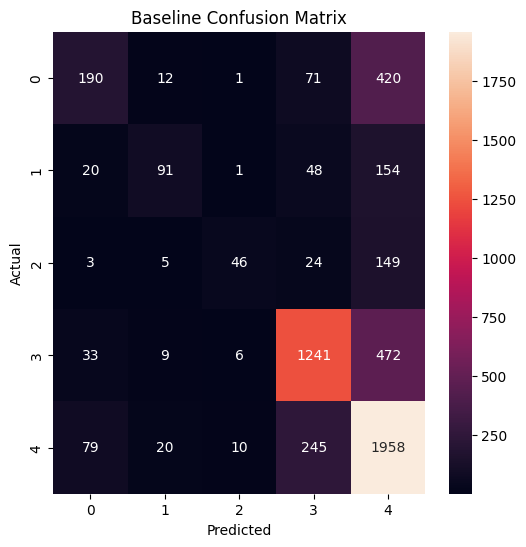

In [7]:
# BASELINE MODEL Logistic Regression for comparision

from datasets import load_dataset
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reload dataset fresh
raw_dataset = load_dataset("go_emotions")


label_names = raw_dataset["train"].features["labels"].feature.names

emotion_groups = {
    "anger": ["anger", "annoyance", "disapproval"],
    "sadness": ["sadness", "disappointment", "grief", "remorse", "embarrassment"],
    "anxiety": ["fear", "nervousness", "confusion"],
    "positive": ["joy", "love", "gratitude", "admiration", "approval", "excitement", "optimism", "relief", "pride", "caring", "desire"],
    "neutral": ["neutral"]
}

label_to_group = {}
for idx, name in enumerate(label_names):
    for group, emotions in emotion_groups.items():
        if name in emotions:
            label_to_group[idx] = group

final_labels = ["anger", "sadness", "anxiety", "positive", "neutral"]
label_encoding = {label: i for i, label in enumerate(final_labels)}

def convert_labels(example):
    if len(example["labels"]) > 0:
        original_label = example["labels"][0]
        group = label_to_group.get(original_label, "neutral")
    else:
        group = "neutral"
    example["labels"] = label_encoding[group]
    return example

raw_dataset = raw_dataset.map(convert_labels)

# ----- Clean text -----
def clean_text(example):
    text = example["text"].lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    example["text"] = text
    return example

raw_dataset = raw_dataset.map(clean_text)

# Remove very short samples
raw_dataset = raw_dataset.filter(lambda x: len(x["text"].split()) > 2)

# ----- Prepare data -----
train_texts = raw_dataset["train"]["text"]
train_labels = raw_dataset["train"]["labels"]

test_texts = raw_dataset["test"]["text"]
test_labels = raw_dataset["test"]["labels"]

# ----- TF-IDF -----
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# ----- Logistic Regression -----
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train_labels)

preds = clf.predict(X_test)

accuracy = accuracy_score(test_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, preds, average="weighted")

print("Baseline Model Results:")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

cm = confusion_matrix(test_labels, preds)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Baseline Confusion Matrix")
plt.show()

In [8]:
# Crisis Detection Module

import torch
import torch.nn.functional as F

# High-Risk Keyword List
high_risk_keywords = [
    "kill myself",
    "want to die",
    "end my life",
    "suicide",
    "harm myself",
    "no reason to live",
    "i can't go on",
    "i dont want to live",
    "i hate my life"
]

# Emotion Labels (must match your label encoding)
label_map = {0: "anger", 1: "sadness", 2: "anxiety", 3: "positive", 4: "neutral"}

# Threshold for severe distress
DISTRESS_THRESHOLD = 0.75

# Crisis Detection Function

def crisis_detection(text):

    text_lower = text.lower()

    # Explicit High-Risk Keyword Check
    for phrase in high_risk_keywords:
        if phrase in text_lower:
            return {
                "risk_level": "HIGH",
                "reason": "Explicit suicidal intent detected"
            }

    # Emotion-Based Detection
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)

    confidence, predicted_class = torch.max(probs, dim=1)

    predicted_label = label_map[predicted_class.item()]
    confidence = confidence.item()

    return {
        "risk_level": "SAFE",
        "reason": "No crisis indicators detected"
    }

# Emergency Response Function

def emergency_response(risk_info):

    if risk_info["risk_level"] == "HIGH":
        return (
            "I'm really sorry that you're feeling this way. "
            "It sounds like you're going through something very painful. "
            "You don’t have to handle this alone.\n\n"
            "Please consider reaching out to a trusted person or a mental health professional immediately.\n"
            "If you're in immediate danger, please contact local emergency services."
        )

    elif risk_info["risk_level"] == "SEVERE":
        return (
            "I can sense that you're going through a very difficult time. "
            "Your feelings are valid and important.\n\n"
            "It might help to talk to someone you trust or consider seeking professional support. "
            "Would you like to try a short grounding exercise together?"
        )

    else:
        return None

In [9]:
!pip install -q bitsandbytes accelerate

In [10]:
# Tiny Llama for empathetic response generation
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Load tokenizer
tiny_tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load model safely
tiny_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

tiny_model.eval()

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear4bit(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm(

In [11]:
# Recommendation System

# Emotion-aware structured recommendations
recommendation_map = {
    "anxiety": {
        "title": "Managing Anxiety",
        "suggestions": [
            "Try the 4-7-8 breathing technique for 2 minutes.",
            "Break your study tasks into smaller, manageable goals.",
            "Take a short 5-minute walk to reset your focus.",
            "Limit caffeine and hydrate well."
        ]
    },

    "sadness": {
        "title": "Coping with Sadness",
        "suggestions": [
            "Write down what you're feeling in a journal.",
            "Reach out to someone you trust and talk openly.",
            "Engage in a small activity you usually enjoy.",
            "Practice self-compassion — remind yourself that it's okay to feel this way."
        ]
    },

    "anger": {
        "title": "Handling Anger",
        "suggestions": [
            "Pause and take 5 slow deep breaths.",
            "Step away from the triggering situation temporarily.",
            "Channel energy into physical movement (stretching or walking).",
            "Reflect before responding to avoid impulsive reactions."
        ]
    },

    "positive": {
        "title": "Maintaining Positivity",
        "suggestions": [
            "Keep doing what’s working for you.",
            "Express gratitude for something today.",
            "Support someone else who may need encouragement."
        ]
    },

    "neutral": {
        "title": "General Well-being",
        "suggestions": [
            "Maintain a balanced routine with sleep and hydration.",
            "Check in with your emotions throughout the day.",
            "Take small mindful breaks during tasks."
        ]
    }
}


# Recommendation generator function
def generate_recommendation(emotion):

    if emotion not in recommendation_map:
        return ""

    rec = recommendation_map[emotion]

    response = f"\n\n--- {rec['title']} ---\n"

    for i, suggestion in enumerate(rec["suggestions"], 1):
        response += f"{i}. {suggestion}\n"

    return response

In [12]:
# final integration

import torch
import torch.nn.functional as F

def chatbot(user_input):

    # Crisis Detection

    risk_info = crisis_detection(user_input)

    if risk_info["risk_level"] == "HIGH":
        return emergency_response(risk_info)

    if risk_info["risk_level"] == "SEVERE":
        return emergency_response(risk_info)

    # Emotion Prediction
    inputs = tokenizer(user_input, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)

    confidence, predicted_class = torch.max(probs, dim=1)
    predicted_label = label_map[predicted_class.item()]

    # TinyLlama Response
    prompt = f"""
You are a compassionate mental health assistant.
The user is feeling {predicted_label}.
Respond with empathy, validation, and gentle support.
Keep the response under 6 sentences.

User: {user_input}
Assistant:
"""

    tiny_inputs = tiny_tokenizer(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        tiny_outputs = tiny_model.generate(
            **tiny_inputs,
            max_new_tokens=200,
            temperature=0.6,
            top_p=0.9,
            repetition_penalty=1.1,
            do_sample=True
        )

    response_text = tiny_tokenizer.decode(tiny_outputs[0], skip_special_tokens=True)

    # Clean assistant prefix if repeated
    if "Assistant:" in response_text:
        response_text = response_text.split("Assistant:")[-1].strip()

    # Structured Recommendation

    recommendation_text = generate_recommendation(predicted_label)

    # Final Output
    final_response = response_text + recommendation_text

    return final_response

In [13]:
!pip install -q gradio

In [14]:
import gradio as gr

# -------------------------
# Wrapper function for Gradio chat
# -------------------------
def chat_interface(user_message, chat_history):
    bot_response = chatbot(user_message)
    chat_history.append((user_message, bot_response))
    return "", chat_history

# -------------------------
# UI Layout
# -------------------------
with gr.Blocks(theme=gr.themes.Soft()) as app:

    # -------- HOME PAGE --------
    home_page = gr.Column(visible=True)
    with home_page:
        gr.Markdown("# AI Mental Health Companion")
        gr.Markdown(
            """
            Welcome to the AI-powered emotional support assistant for students.

            This system:
            - Detects emotional state
            - Provides empathetic responses
            - Suggests coping strategies
            - Includes crisis safety detection

            ⚠️ This chatbot is not a replacement for professional mental health support.
            """
        )
        start_button = gr.Button("Start Chat 💬")

    # -------- CHAT PAGE --------
    chat_page = gr.Column(visible=False)
    with chat_page:
        gr.Markdown("## 💬 Talk to the Assistant")

        chatbot_ui = gr.Chatbot()
        msg = gr.Textbox(placeholder="Type your message here...")
        clear = gr.Button("Clear Chat")
        back_button = gr.Button("⬅ Back to Home")

        msg.submit(chat_interface, [msg, chatbot_ui], [msg, chatbot_ui])
        clear.click(lambda: [], None, chatbot_ui)

    # -------- Navigation Logic --------
    def go_to_chat():
        return gr.update(visible=False), gr.update(visible=True)

    def go_to_home():
        return gr.update(visible=True), gr.update(visible=False)

    start_button.click(go_to_chat, outputs=[home_page, chat_page])
    back_button.click(go_to_home, outputs=[home_page, chat_page])

app.launch()

/tmp/ipython-input-2240/3771801836.py:14: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as app:
/tmp/ipython-input-2240/3771801836.py:40: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot_ui = gr.Chatbot()
/tmp/ipython-input-2240/3771801836.py:40: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot_ui = gr.Chatbot()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2219bb3b52dbdcaaf2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
